## Absolute Prominence Task - Differential Entropy and Control functions 

In [1]:
from src.data.components.helsinki import HelsinkiProminenceExtractor
from src.data.components.datasets import TokenTaggingDataset
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
import numpy as np
import os
from tqdm import tqdm

from src.utils.text_processing import python_lowercase_remove_punctuation
from src.utils.text_processing import get_wordlist_from_string

# only to create a valid dataset
dummy_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_special_tokens=True)

/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
DATA_DIR = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/data/Helsinki"
SAVE_DIR = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/predictions/emnlp/prominence_relative_mean"

In [3]:
train_extractor = HelsinkiProminenceExtractor(
    DATA_DIR,
    "train_360.txt",
)
train_texts = train_extractor.get_all_texts()
train_prominences = train_extractor.get_all_real_prominence()

dev_extractor = HelsinkiProminenceExtractor(
    DATA_DIR,
    "dev.txt",
)
dev_texts = dev_extractor.get_all_texts()
dev_prominences = dev_extractor.get_all_real_prominence()

test_extractor = HelsinkiProminenceExtractor(
    DATA_DIR,
    "test.txt",
)
test_texts = test_extractor.get_all_texts()
test_prominences = test_extractor.get_all_real_prominence()

print(
    f"train_texts: {len(train_texts)}, dev_texts: {len(dev_texts)}, test_texts: {len(test_texts)}"
)

train_texts: 116263, dev_texts: 5727, test_texts: 4822


In [4]:
train_words = [word for text in train_texts for word in text.split()]
dev_words = [word for text in dev_texts for word in text.split()]
test_words = [word for text in test_texts for word in text.split()]

print(
    f"train_words: {len(train_words)}, dev_words: {len(dev_words)}, test_words: {len(test_words)}"
)

train_words: 2378175, dev_words: 113599, test_words: 102646


In [5]:
GLOBAL_MEAN_PROMINENCE = np.mean([p for ps in train_prominences for p in ps if p])
GLOBAL_MEAN_PROMINENCE

0.801785040963262

In [6]:
import pandas as pd
import json

stats_path = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/data/Helsinki/word_to_stats_cased.json"

word_stats = json.load(open(stats_path, "r"))

In [7]:
train_dataset = TokenTaggingDataset(
    input_texts=train_texts,
    targets=train_prominences,
    tokenizer=dummy_tokenizer,
    model_name="gpt2",
    score_last_token=True,
    relative_to_mean=True,
    word_stats=word_stats,
)

dev_dataset = TokenTaggingDataset(
    input_texts=dev_texts,
    targets=dev_prominences,
    tokenizer=dummy_tokenizer,
    model_name="gpt2",
    score_last_token=True,
    relative_to_mean=True,
    word_stats=word_stats,
)

test_dataset = TokenTaggingDataset(
    input_texts=test_texts,
    targets=test_prominences,
    tokenizer=dummy_tokenizer,
    model_name="gpt2",
    score_last_token=True,
    relative_to_mean=True,
    word_stats=word_stats,
)

Preprocessing samples: 100%|██████████| 116263/116263 [00:51<00:00, 2260.63it/s]


Failed 7657/116263


Preprocessing samples: 100%|██████████| 5727/5727 [00:03<00:00, 1814.04it/s]


Failed 328/5727


Preprocessing samples: 100%|██████████| 4822/4822 [00:02<00:00, 2377.86it/s]

Failed 325/4822


In [8]:
train_sentences = []
train_labels = []
for i in range(len(train_dataset)):
    item = train_dataset.__getitem__(i)
    train_sentences.append(item["input_text"])
    mask = np.array(item["loss_mask"])
    labels = np.array(item["tokenized_labels"])
    valid_labels = np.array(labels[mask == 1])
    train_labels.append(valid_labels)

test_sentences = []
test_labels = []
for i in range(len(test_dataset)):
    item = test_dataset.__getitem__(i)
    test_sentences.append(item["input_text"])
    mask = np.array(item["loss_mask"])
    labels = np.array(item["tokenized_labels"])
    valid_labels = np.array(labels[mask == 1])
    test_labels.append(valid_labels)

dev_sentences = []
dev_labels = []
for i in range(len(dev_dataset)):
    item = dev_dataset.__getitem__(i)
    dev_sentences.append(item["input_text"])
    mask = np.array(item["loss_mask"])
    labels = np.array(item["tokenized_labels"])
    valid_labels = np.array(labels[mask == 1])
    dev_labels.append(valid_labels)

print(
    f"train_sentences: {len(train_sentences)}, dev_sentences: {len(dev_sentences)}, test_sentences: {len(test_sentences)}"
)

train_sentences: 108606, dev_sentences: 5399, test_sentences: 4497


In [9]:
from src.utils.text_processing import assign_labels_to_sentences

all_train_words, all_train_labels = assign_labels_to_sentences(
    train_sentences, train_labels
)
all_dev_words, all_dev_labels = assign_labels_to_sentences(dev_sentences, dev_labels)

all_test_words, all_test_labels = assign_labels_to_sentences(
    test_sentences, test_labels
)


print(len(all_train_words), len(all_train_labels))
print(len(all_dev_words), len(all_dev_labels))
print(len(all_test_words), len(all_test_labels))

1835868 1835868
91509 91509
80422 80422


### Kernel density estimation and Differential Entropy Computation

In [10]:
all_train_labels = np.array(all_train_labels)
all_dev_labels = np.array(all_dev_labels)
all_test_labels = np.array(all_test_labels)
all_train_labels.shape, all_dev_labels.shape, all_test_labels.shape

((1835868,), (91509,), (80422,))

In [12]:
# bootstrapping to get confidence intervals
from sklearn.utils import resample
from scipy.stats import gaussian_kde
from src.utils.approximation import cross_validate_gkde_bandwidth
from src.utils.approximation import monte_carlo_diff_entropy

n_iterations = 10
n_train_size = int(len(all_train_labels) * 0.2)
n_dev_size = int(len(all_dev_labels) * 0.02)
n_test_size = int(len(all_test_labels) * 0.2)
print(
    f"n_train_size: {n_train_size}, n_dev_size: {n_dev_size}, n_test_size: {n_test_size}"
)

diff_entropy_list = []

for i in range(n_iterations):
    train_sample = resample(all_train_labels, n_samples=n_train_size)
    dev_sample = resample(all_dev_labels, n_samples=n_dev_size)
    test_sample = resample(all_test_labels, n_samples=n_test_size)
    best_bw = 0.01
    # best_bw = cross_validate_gkde_bandwidth(train_sample, dev_sample)
    print(f"Best bandwidth: {best_bw}")
    density = gaussian_kde(all_train_labels, bw_method=best_bw)
    mc_entropy = monte_carlo_diff_entropy(density, test_sample, len(test_sample))
    diff_entropy_list.append(mc_entropy)
    print(
        f"Finished iteration {i+1} out of {n_iterations} with diff entropy: {mc_entropy}"
    )

diff_entropy_list = np.array(diff_entropy_list)
print(f"Mean: {np.mean(diff_entropy_list)}, std: {np.std(diff_entropy_list)}")

n_train_size: 367173, n_dev_size: 1830, n_test_size: 16084
Best bandwidth: 0.01
Finished iteration 1 out of 10 with diff entropy: 0.7794972266668835
Best bandwidth: 0.01
Finished iteration 2 out of 10 with diff entropy: 0.7863980249636994
Best bandwidth: 0.01
Finished iteration 3 out of 10 with diff entropy: inf
Best bandwidth: 0.01
Finished iteration 4 out of 10 with diff entropy: 0.764301553302369
Best bandwidth: 0.01
Finished iteration 5 out of 10 with diff entropy: 0.8005079024893422
Best bandwidth: 0.01
Finished iteration 6 out of 10 with diff entropy: 0.7875693340946458
Best bandwidth: 0.01
Finished iteration 7 out of 10 with diff entropy: 0.7783301434464783
Best bandwidth: 0.01
Finished iteration 8 out of 10 with diff entropy: 0.7872701577677099
Best bandwidth: 0.01


In [10]:
# Find best kde bandwidth

from src.utils.approximation import cross_validate_gkde_bandwidth

best_bandwidth = cross_validate_gkde_bandwidth(
    all_train_labels[:20000], all_dev_labels[:5000]
)
best_bandwidth

param scott, score -0.85262890771163
new best param scott, score -0.85262890771163
param silverman, score -0.8511822668975448
new best param silverman, score -0.8511822668975448
param 0.01, score -4.539221671880821
param 0.1, score -0.8670126516260005
param 0.2, score -0.8474487790686742
new best param 0.2, score -0.8474487790686742
param 0.5, score -0.8767897684099402


0.2

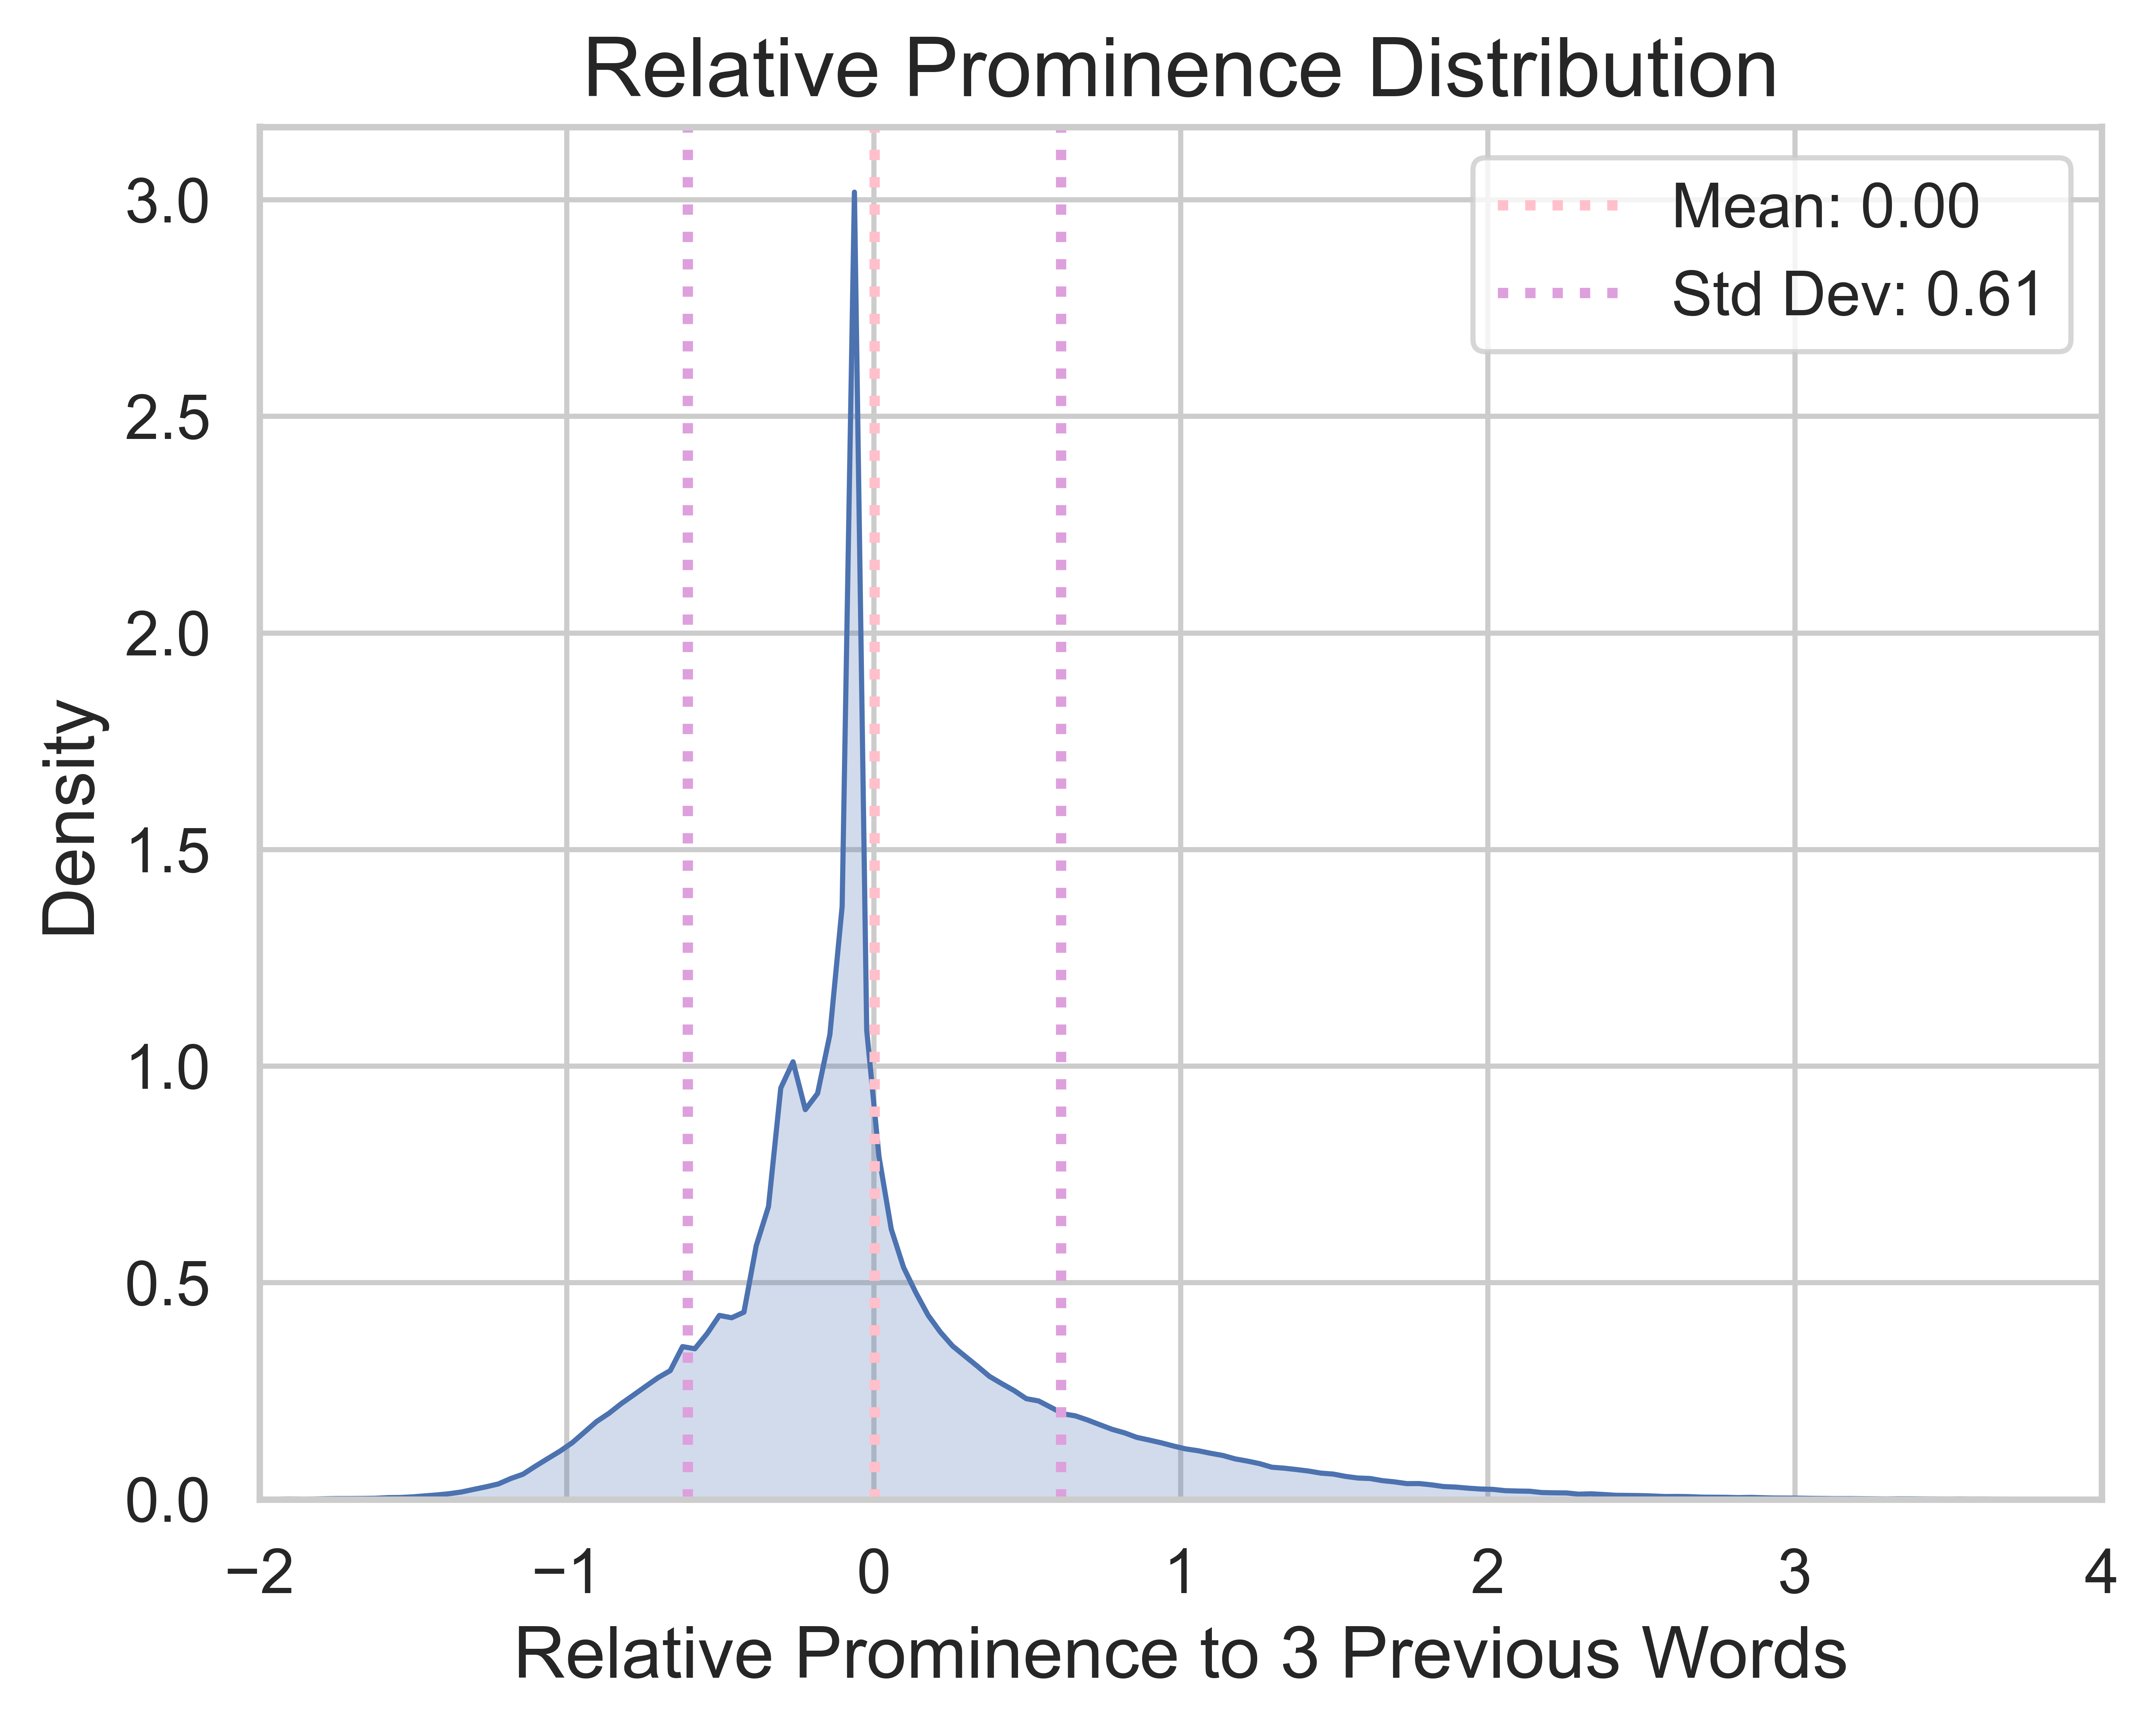

In [11]:
from src.utils.plots import plot_kde

plot_kde(
    data=all_train_labels,
    bw_adjust=0.2,
    label_name="Relative Prominence to 3 Previous Words",
    title="Relative Prominence Distribution",
    x_range=(-2, 4),
)

In [12]:
# kernel density estimation
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

density = gaussian_kde(all_train_labels, bw_method=0.2)

# xs = np.linspace(0, 6, 1000)
# plt.plot(xs, density(xs))
# plt.show()

In [13]:
from src.utils.approximation import monte_carlo_diff_entropy

diff_entropy = monte_carlo_diff_entropy(density, all_test_labels, num_samples=5000)
diff_entropy

0.8171574521213392

## Store text and labels as pickle 

In [14]:
SAVE_PATH = (
    "/Users/lukas/Desktop/projects/MIT/data/baseline_data/prominence_relative_mean"
)

In [15]:
import pickle

with open(SAVE_PATH + "/train_words.pkl", "wb") as f:
    pickle.dump(all_train_words, f)

with open(SAVE_PATH + "/train_labels.pkl", "wb") as f:
    pickle.dump(all_train_labels, f)

with open(SAVE_PATH + "/test_words.pkl", "wb") as f:
    pickle.dump(all_test_words, f)

with open(SAVE_PATH + "/test_labels.pkl", "wb") as f:
    pickle.dump(all_test_labels, f)

with open(SAVE_PATH + "/dev_words.pkl", "wb") as f:
    pickle.dump(all_dev_words, f)

with open(SAVE_PATH + "/dev_labels.pkl", "wb") as f:
    pickle.dump(all_dev_labels, f)

# Baseline Models and Control Functions 

In [16]:
# load data again

import pickle

SAVE_PATH = (
    "/Users/lukas/Desktop/projects/MIT/data/baseline_data/prominence_relative_mean"
)

with open(SAVE_PATH + "/train_words.pkl", "rb") as f:
    all_train_words = pickle.load(f)

with open(SAVE_PATH + "/train_labels.pkl", "rb") as f:
    all_train_labels = pickle.load(f)

with open(SAVE_PATH + "/test_words.pkl", "rb") as f:
    all_test_words = pickle.load(f)

with open(SAVE_PATH + "/test_labels.pkl", "rb") as f:
    all_test_labels = pickle.load(f)

with open(SAVE_PATH + "/dev_words.pkl", "rb") as f:
    all_dev_words = pickle.load(f)

with open(SAVE_PATH + "/dev_labels.pkl", "rb") as f:
    all_dev_labels = pickle.load(f)

print(len(all_train_words), len(all_train_labels))
print(len(all_dev_words), len(all_dev_labels))
print(len(all_test_words), len(all_test_labels))

1835868 1835868
91509 91509
80422 80422


In [17]:
from src.models.baselines.GloVe import GloVeModel

glove_model = GloVeModel(
    model_path="/Users/lukas/Desktop/projects/MIT/data/models/glove/glove.6B.100d.txt"
)

Loading GloVe: 100%|██████████| 400000/400000 [00:05<00:00, 68689.92it/s]


In [18]:
train_emb = [glove_model.get_word_embedding(word) for word in all_train_words]
dev_emb = [glove_model.get_word_embedding(word) for word in all_dev_words]
test_emb = [glove_model.get_word_embedding(word) for word in all_test_words]

In [19]:
print(
    f"Shapes of train, dev, test embeddings: {len(train_emb)}, {len(dev_emb)}, {len(test_emb)}"
)

Shapes of train, dev, test embeddings: 1835868, 91509, 80422


In [20]:
# create numpy arrays and print shapes
import numpy as np

train_emb = np.array(train_emb)
dev_emb = np.array(dev_emb)
test_emb = np.array(test_emb)

train_labels = np.array(all_train_labels)
dev_labels = np.array(all_dev_labels)
test_labels = np.array(all_test_labels)


print(
    f"Shapes of train, dev, test embeddings: {train_emb.shape}, {dev_emb.shape}, {test_emb.shape}"
)

print(
    f"Shapes of train, dev, test labels: {train_labels.shape}, {dev_labels.shape}, {test_labels.shape}"
)

Shapes of train, dev, test embeddings: (1835868, 100), (91509, 100), (80422, 100)
Shapes of train, dev, test labels: (1835868,), (91509,), (80422,)


# Sklearn LinReg

In [21]:
# train sklearn model
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(train_emb, all_train_labels)

# compute mse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

predictions = reg.predict(test_emb)
mse = mean_absolute_error(all_test_labels, predictions)
print(f"Mean absolute error: {mse}")

# compute r2
r2 = r2_score(all_test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(all_test_labels, predictions)
print(f"Pearson correlation: {pearson}")

Mean absolute error: 0.4509447236384437
R2 score: 0.0009220788121948598
Pearson correlation: PearsonRResult(statistic=0.045775102378098925, pvalue=1.4337417462322318e-38)


## SKlearn hist grad boost

In [15]:
# hist grad boost
from sklearn.ensemble import HistGradientBoostingRegressor

reg = HistGradientBoostingRegressor().fit(train_emb, all_train_labels)

# compute mse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

predictions = reg.predict(test_emb)
mse = mean_absolute_error(all_test_labels, predictions)
print(f"Mean absolute error: {mse}")

# compute r2
r2 = r2_score(all_test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(all_test_labels, predictions)
print(f"Pearson correlation: {pearson}")

Mean absolute error: 0.4571809180232205
R2 score: 0.35939290700740123
Pearson correlation: PearsonRResult(statistic=0.5996386386797646, pvalue=0.0)


## Sklearn MLP

In [20]:
# mlp

from sklearn.neural_network import MLPRegressor

reg = MLPRegressor(max_iter=1).fit(train_emb, all_train_labels)

# compute mse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

predictions = reg.predict(test_emb)
mse = mean_absolute_error(all_test_labels, predictions)
print(f"Mean absolute error: {mse}")

# compute r2
r2 = r2_score(all_test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(all_test_labels, predictions)
print(f"Pearson correlation: {pearson}")

Mean absolute error: 0.44387074945747557
R2 score: 0.3334262296404742
Pearson correlation: PearsonRResult(statistic=0.5930757981729451, pvalue=0.0)


/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
import torch
from torch import nn
from torch.optim import SGD
from torch.distributions import Normal


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_p):
        super(MLP, self).__init__()
        self.layers = self._build_layers(
            input_size, hidden_size, output_size, num_layers, dropout_p
        )

    def _build_layers(
        self, input_size, hidden_size, output_size, num_layers, dropout_p
    ):
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_p))
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_p))
        layers.append(nn.Linear(hidden_size, output_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


def gnll_loss(output, target):
    mean, std = output[:, 0], torch.exp(
        output[:, 1]
    )  # assume second output is log(std)
    dist = Normal(mean, std)
    return -dist.log_prob(target).mean()  # negative log likelihood


def train():
    # Assume input size of 10, hidden size of 20, output size of 2 (mean and log(std))
    model = MLP(100, 20, 2, num_layers=2, dropout_p=0)
    optimizer = SGD(model.parameters(), lr=0.01)

    # Mock some data
    data = torch.from_numpy(train_emb).float()  # 1000 data points
    targets = torch.from_numpy(train_labels).float()  # 1000 targets

    for epoch in range(1000):  # 100 training epochs
        optimizer.zero_grad()
        outputs = model(data)
        loss = gnll_loss(outputs, targets)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:  # print progress every 10 epochs
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

In [13]:
train()

Epoch: 0, Loss: 1.4665346145629883
Epoch: 10, Loss: 1.4317411184310913
Epoch: 20, Loss: 1.3993971347808838
Epoch: 30, Loss: 1.3686869144439697
Epoch: 40, Loss: 1.339741826057434
Epoch: 50, Loss: 1.3127869367599487
Epoch: 60, Loss: 1.2882744073867798
Epoch: 70, Loss: 1.2663682699203491
Epoch: 80, Loss: 1.2472020387649536
Epoch: 90, Loss: 1.230863332748413
Epoch: 100, Loss: 1.2175074815750122
Epoch: 110, Loss: 1.2065781354904175
Epoch: 120, Loss: 1.1978747844696045
Epoch: 130, Loss: 1.1910836696624756
Epoch: 140, Loss: 1.185595154762268
Epoch: 150, Loss: 1.1811168193817139
Epoch: 160, Loss: 1.1772929430007935
Epoch: 170, Loss: 1.1737799644470215
Epoch: 180, Loss: 1.1704620122909546
Epoch: 190, Loss: 1.1671898365020752
Epoch: 200, Loss: 1.1638103723526
Epoch: 210, Loss: 1.160293698310852
Epoch: 220, Loss: 1.1565134525299072
Epoch: 230, Loss: 1.1526975631713867
Epoch: 240, Loss: 1.1488804817199707
Epoch: 250, Loss: 1.1448695659637451
Epoch: 260, Loss: 1.1412707567214966
Epoch: 270, Loss: 1